## 콜레스테롤 수치 예측 모델 ##

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 로딩
df = pd.read_csv("./data/health_2023_cleaned_final.csv")

# 파생변수 추가: BMI, 허리신장비
df['BMI'] = (df['체중(5kg단위)'] + 2.5) / ((df['신장(5cm단위)'] + 2.5) / 100) ** 2
df['허리신장비'] = df['허리둘레'] / (df['신장(5cm단위)'] + 2.5)

# 전처리: 결측치 제거 (파생변수 포함)
df = df.dropna(subset=[
    '연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '흡연상태', '음주여부', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
    '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
    'BMI', '허리신장비'
])

# Feature & Target 설정
X = df[['연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
        '흡연상태', '음주여부', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
        'BMI', '허리신장비']]
targets = ['총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤']

# 모델 학습 및 평가
for target in targets:
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=50, max_depth=3, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n[{target}] 예측 성능:")
    print("R2:", r2_score(y_test, y_pred))



[총콜레스테롤] 예측 성능:
R2: 0.12029694980483607

[트리글리세라이드] 예측 성능:
R2: 0.1791201808905405

[HDL콜레스테롤] 예측 성능:
R2: 0.21518285294045258

[LDL콜레스테롤] 예측 성능:
R2: 0.10111984984295752


## 테스트 ##


🔍 [총콜레스테롤] 상세 분석
📌 Baseline → MAE: 33.32, RMSE: 41.92, R2: -0.0000
📌 LinearRegression → MAE: 32.15, RMSE: 40.38, R2: 0.0722
📌 XGBoost → MAE: 31.08, RMSE: 39.32, R2: 0.1203


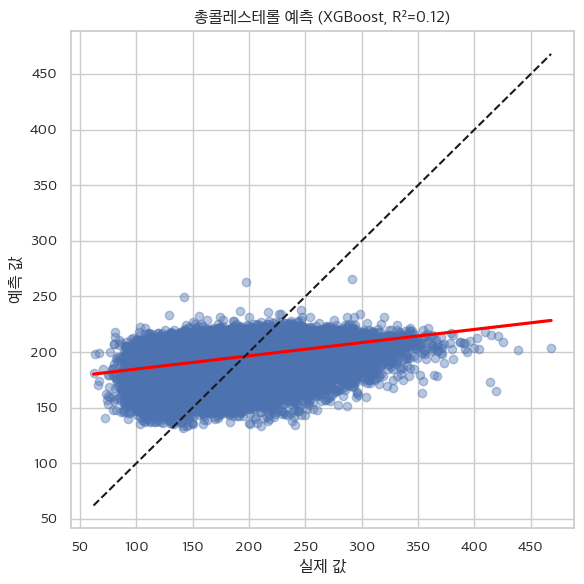

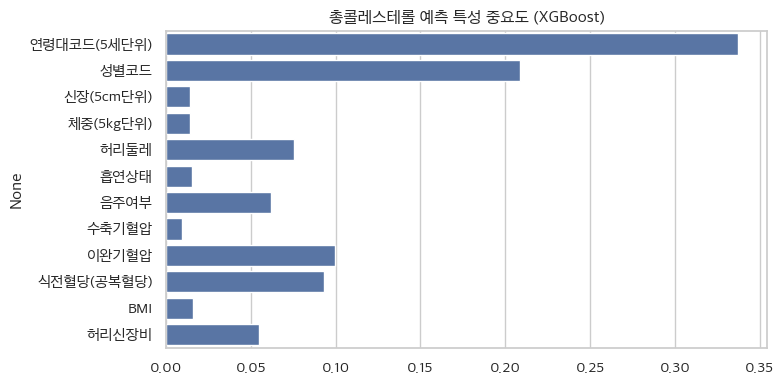

📎 XGBoost 교차검증 R² 평균: 0.1185 (std: 0.0026)
🔗 상관분석 (허리신장비 ↔ 총콜레스테롤)
  피어슨 r = -0.079, p = 0.0000
  스피어만 ρ = -0.080, p = 0.0000

🔍 [트리글리세라이드] 상세 분석
📌 Baseline → MAE: 50.89, RMSE: 66.74, R2: -0.0000
📌 LinearRegression → MAE: 46.00, RMSE: 61.36, R2: 0.1548
📌 XGBoost → MAE: 45.23, RMSE: 60.47, R2: 0.1791


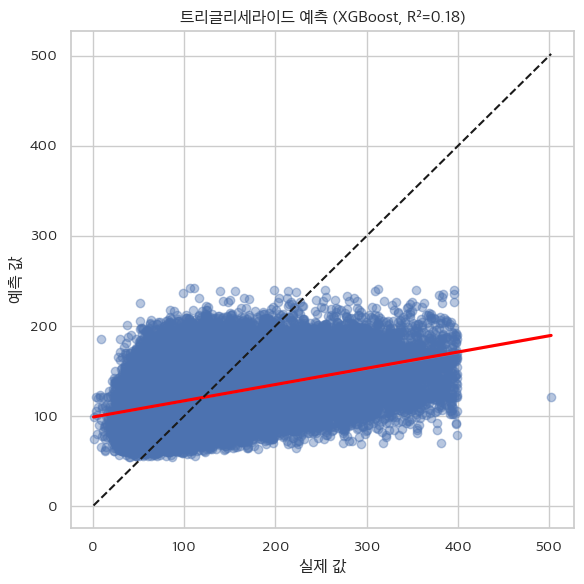

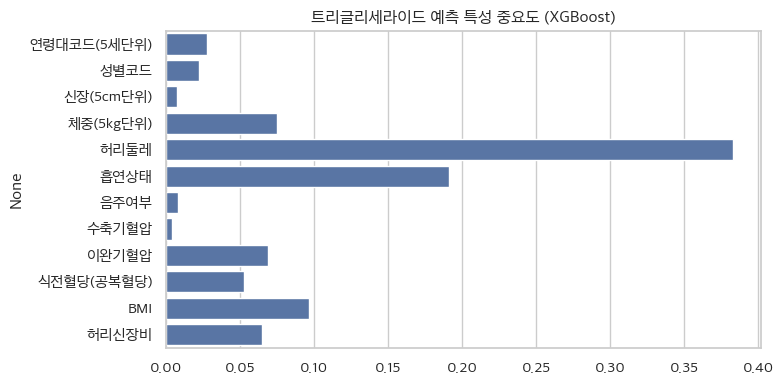

📎 XGBoost 교차검증 R² 평균: 0.1810 (std: 0.0032)
🔗 상관분석 (허리신장비 ↔ 트리글리세라이드)
  피어슨 r = 0.273, p = 0.0000
  스피어만 ρ = 0.320, p = 0.0000

🔍 [HDL콜레스테롤] 상세 분석
📌 Baseline → MAE: 11.70, RMSE: 14.95, R2: -0.0000
📌 LinearRegression → MAE: 10.35, RMSE: 13.40, R2: 0.1962
📌 XGBoost → MAE: 10.22, RMSE: 13.24, R2: 0.2152


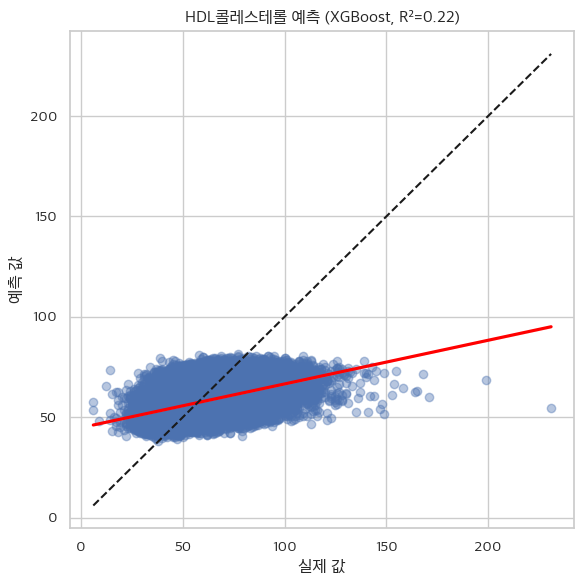

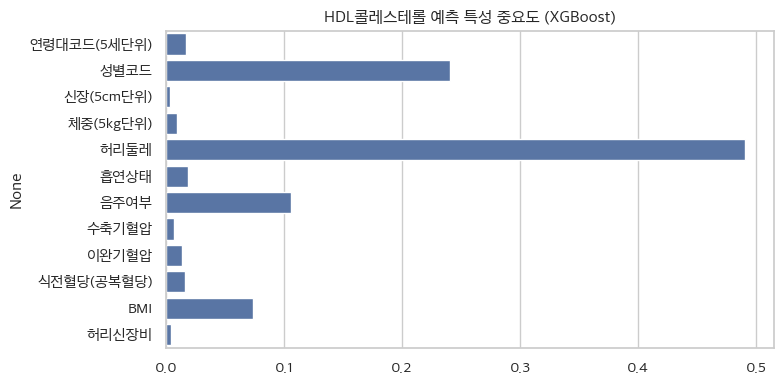

📎 XGBoost 교차검증 R² 평균: 0.2212 (std: 0.0037)
🔗 상관분석 (허리신장비 ↔ HDL콜레스테롤)
  피어슨 r = -0.308, p = 0.0000
  스피어만 ρ = -0.318, p = 0.0000

🔍 [LDL콜레스테롤] 상세 분석
📌 Baseline → MAE: 30.39, RMSE: 38.08, R2: -0.0000
📌 LinearRegression → MAE: 29.51, RMSE: 37.02, R2: 0.0548
📌 XGBoost → MAE: 28.58, RMSE: 36.10, R2: 0.1011


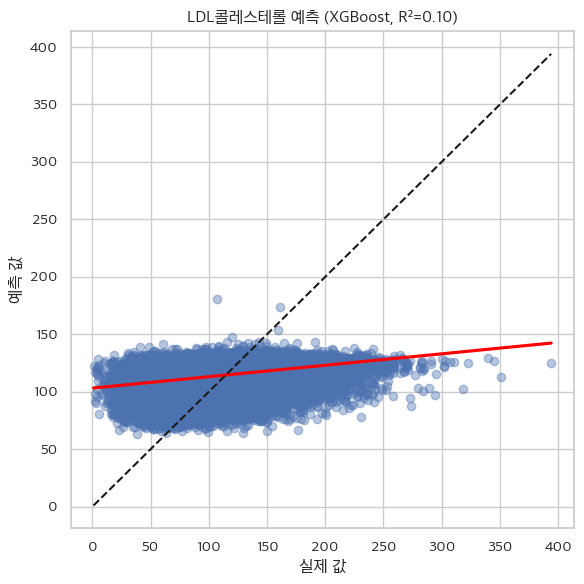

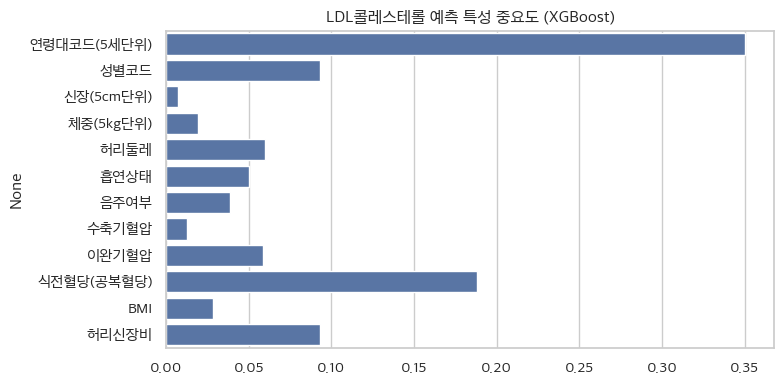

📎 XGBoost 교차검증 R² 평균: 0.0973 (std: 0.0029)
🔗 상관분석 (허리신장비 ↔ LDL콜레스테롤)
  피어슨 r = -0.061, p = 0.0000
  스피어만 ρ = -0.062, p = 0.0000


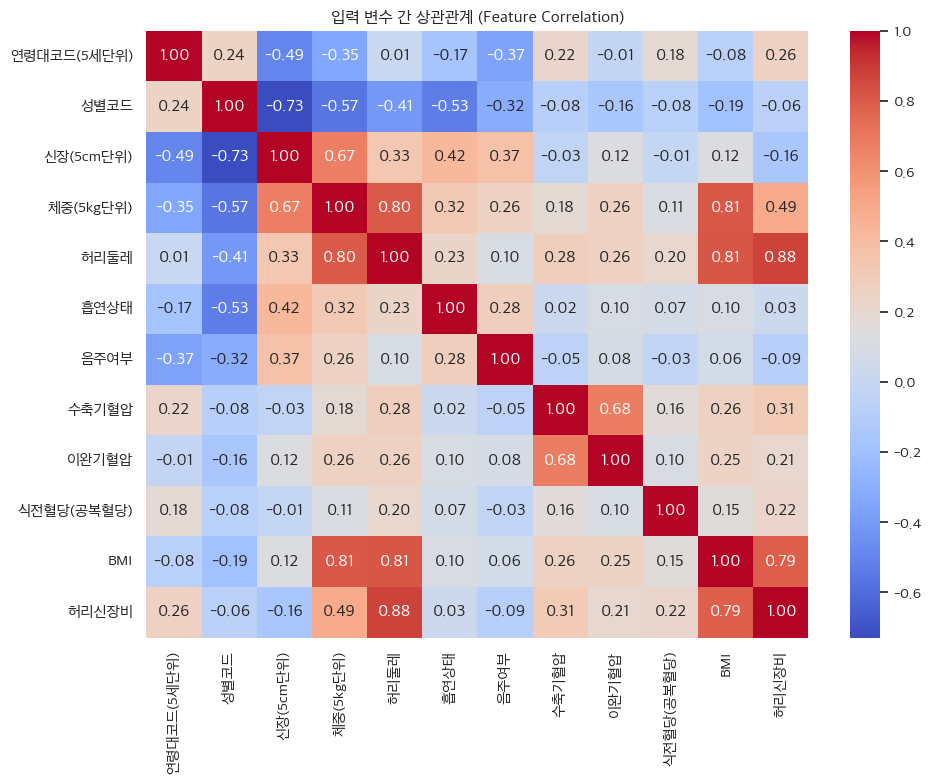

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 시각화 설정
sns.set(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 (macOS 기준)
font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc' # macOS 기본 한글 폰트 경로 예시

font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 교차검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 타겟별 테스트 루프
for target in targets:
    print(f"\n🔍 [{target}] 상세 분석")

    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "Baseline": DummyRegressor(strategy="mean"),
        "LinearRegression": LinearRegression(),
        "XGBoost": XGBRegressor(n_estimators=50, max_depth=3, verbosity=0)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"📌 {name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

        if name == "XGBoost":
            # 예측 vs 실제 시각화
            plt.figure(figsize=(6, 6))
            sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.4}, line_kws={"color": "red"})
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
            plt.xlabel("실제 값")
            plt.ylabel("예측 값")
            plt.title(f"{target} 예측 (XGBoost, R²={r2:.2f})")
            plt.tight_layout()
            plt.show()

            # 특성 중요도 시각화
            importances = model.feature_importances_
            features = X.columns
            plt.figure(figsize=(8, 4))
            sns.barplot(x=importances, y=features)
            plt.title(f"{target} 예측 특성 중요도 (XGBoost)")
            plt.tight_layout()
            plt.show()

    # 교차검증 (XGBoost)
    scores = cross_val_score(XGBRegressor(n_estimators=50, max_depth=3, verbosity=0),
                              X, y, cv=kf, scoring='r2')
    print(f"📎 XGBoost 교차검증 R² 평균: {np.mean(scores):.4f} (std: {np.std(scores):.4f})")

    # 상관분석: 허리신장비와 타겟
    pearson_corr, pearson_p = pearsonr(df['허리신장비'], y)
    spearman_corr, spearman_p = spearmanr(df['허리신장비'], y)
    print(f"🔗 상관분석 (허리신장비 ↔ {target})")
    print(f"  피어슨 r = {pearson_corr:.3f}, p = {pearson_p:.4f}")
    print(f"  스피어만 ρ = {spearman_corr:.3f}, p = {spearman_p:.4f}")

# 전체 히트맵
plt.figure(figsize=(10, 8))
corr = df[X.columns].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("입력 변수 간 상관관계 (Feature Correlation)")
plt.tight_layout()
plt.show()
